In [6]:
from dataset import SubjectTrialDataset_SingleElectrode
from subject_braintreebank import BrainTreebankSubject
import torch
from model_model import BFModule
from model_transformers import Transformer
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

subject_id, trial_id = 3, 0
window_size = 100
subject = BrainTreebankSubject(subject_id, cache=True)
dataset = SubjectTrialDataset_SingleElectrode(subject, trial_id, window_size=window_size, dtype=torch.float32, unsqueeze_electrode_dimension=False)

Using device: cuda


In [ ]:
class Embed(BFModule):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Linear(d_input, d_model)
    def forward(self, x):
        return self.embed(x)

class Model(BFModule):
    def __init__():
        pass

    def generate_continuation_contrastive(self, batch, n_steps, vocab):
        """
        Generate a continuation of the input sequence for n_steps steps.
        
        Args:
            batch: Input sequence of shape (batch_size, seq_len, 1)
            n_steps: Number of steps to generate
            vocab: Tensor of possible samples to choose from, shape (n_samples, d_model)
        
        Returns:
            Tensor of shape (batch_size, seq_len + n_steps, 1) containing the original sequence
            concatenated with the generated continuation
        """
        # Start with the input batch
        current_sequence = batch.clone()
        # Generate n_steps new timesteps
        for _ in range(n_steps):
            # Get next step prediction
            next_values = self.generate_next_step(current_sequence, vocab).unsqueeze(1).unsqueeze(-1)
            # Concatenate with current sequence
            current_sequence = torch.cat([current_sequence, next_values], dim=1)
        return current_sequence

class ContrastiveModel(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super().__init__()
        device = self.device
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.embed = nn.Linear(d_input, d_model)
        self.unembed = nn.Linear(d_input, d_model)
        self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
                                        n_layer=n_layers, n_head=n_heads, causal=True, 
                                        rope=True, cls_token=False, rope_base=200 // d_input)
    
    def forward(self, x, y):
        # x is of shape (batch_size, seq_len, d_input)
        # y is of shape (batch_size, seq_len, d_input)
        x = self.embed(x) # shape (batch_size, seq_len, d_model)
        y = self.unembed(y) # shape (batch_size, seq_len, d_model)

        x = self.transformer(x) # shape (batch_size, seq_len, d_model)

        x = x / x.norm(dim=-1, keepdim=True)
        y = y / y.norm(dim=-1, keepdim=True)
        return x, y
        
    def calculate_loss(self, batch):
        # batch is of shape (batch_size, seq_len, d_input)
        x, y = self(batch[:, :-1], batch[:, 1:])
        batch_size = batch.shape[0]

        similarity = torch.matmul(x[:, :].permute(1, 0, 2), y[:, :].permute(1, 2, 0))
        expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(x.shape[1]-1, 1).to(device, dtype=torch.long).reshape(-1)
        loss = torch.nn.functional.cross_entropy(similarity.view(-1, batch_size), expanded_arange)
        return loss
    
    def generate_next_step(self, batch, vocab):
        # batch is of shape (batch_size, seq_len, 1)
        # vocab is of shape (n_samples,)
        x = batch
        y = vocab.unsqueeze(0).unsqueeze(-1) # shape (1, n_samples, 1)
        x, y = self(x, y)
        last_x = x[:, -1:] # shape (batch_size, 1, d_model)
        
        # Calculate similarity with all possible next steps
        similarity = torch.matmul(last_x, y.transpose(-2, -1)) # shape (batch_size, 1, seq_len)
        # Convert to probabilities
        probs = torch.softmax(similarity.squeeze(1), dim=-1)
        # Sample from probability distribution
        next_idx = torch.multinomial(probs, num_samples=1).squeeze(-1)
        next_value = vocab[next_idx]
        return next_value
    
class RawL2Model(Model):
    def __init__(self, d_model=128, n_layers=4, n_heads=8, d_input=1):
        super().__init__()
        self.d_input = d_input
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.embed = torch.nn.Linear(d_input, d_model)
        self.unembed = torch.nn.Linear(d_model, d_input)
        self.transformer = Transformer(d_input=d_model, d_model=d_model, d_output=d_model, 
                                        n_layer=n_layers, n_head=n_heads, causal=True, 
                                        rope=True, cls_token=False, rope_base=200 // d_input)
        
    def forward(self, x):
        x = self.embed(x) # shape (batch_size, seq_len, d_model)
        x = self.transformer(x) # shape (batch_size, seq_len, d_model)
        x = self.unembed(x) # shape (batch_size, seq_len, d_input)
        return x
        
    def calculate_loss(self, batch):
        x = self(batch[:, :-1])
        y = batch[:, 1:]
        loss = (x-y).pow(2).mean()
        return loss
    
    def generate_next_step(self, batch):
        x = self(batch)[:, -1:]
        return x

: 

In [ ]:
n_steps = 10000
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


n_samples_per_bin = 1
model = RawL2Model(d_input=n_samples_per_bin)

use_muon = False
optimizers = []
if use_muon:
    from muon import Muon
    all_params = list(model.parameters())
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]
    optimizers.append(Muon(matrix_params, lr=1e-4, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5))
    optimizers.append(torch.optim.AdamW(other_params, lr=1e-4, betas=(0.9, 0.95)))
else:
    optimizers = [torch.optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95))]

step = 1
for batch in dataloader:
    for optimizer in optimizers:
        optimizer.zero_grad()

    batch_data = batch['data'].to(device).reshape(batch_size, window_size//n_samples_per_bin, n_samples_per_bin) # shape (batch_size, seq_len, 1)
    
    loss = model.calculate_loss(batch_data)
    loss.backward()
    for optimizer in optimizers:
        optimizer.step()
    
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")
        
    if step == n_steps:
        break # Only process one batch per step
    step += 1


Step 100, Loss: 1.8021
Step 200, Loss: 0.0035
Step 300, Loss: 0.0003
Step 400, Loss: 0.0001
Step 500, Loss: 0.0005
Step 600, Loss: 0.0025
Step 700, Loss: 0.0003


KeyboardInterrupt: 

In [55]:
import random

vocab_size = 10000
vocab = []
for i in range(vocab_size // (window_size // n_samples_per_bin)):
    vocab.append(dataset[random.randint(0, len(dataset)-1)]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin))
vocab = torch.cat(vocab, dim=0)
vocab = vocab.to(device)
vocab_size = len(vocab)
print(vocab.shape)

(torch.Size([10000]), torch.Size([10000, 128]))

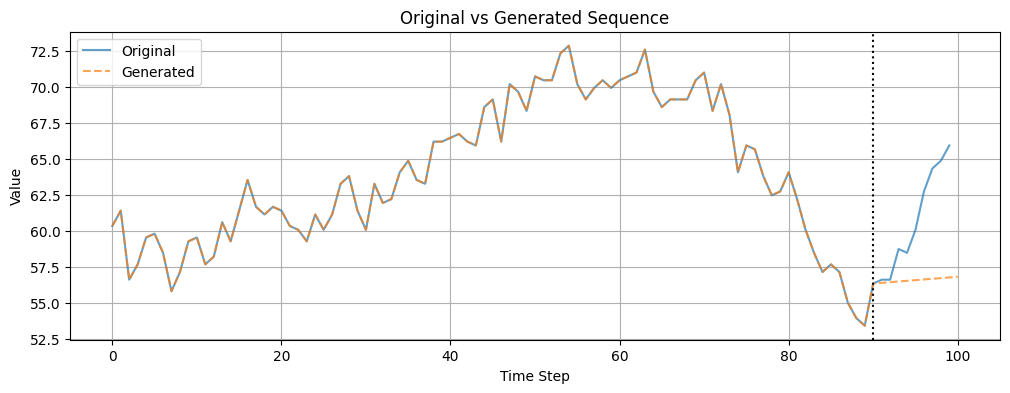

In [58]:
generate_steps = 10

example_seq = dataset[0]['data'].unsqueeze(0).unsqueeze(-1).to(device)
continued_seq = generate_continuation_l2(example_seq[:, :len(example_seq)-generate_steps], generate_steps)


import matplotlib.pyplot as plt

# Plot original and continued sequences
plt.figure(figsize=(12,4))

# Plot original sequence
plt.plot(example_seq[0,:,0].detach().cpu().numpy(), label='Original', alpha=0.7)

# Plot continued sequence 
plt.plot(continued_seq[0,:,0].detach().cpu().numpy(), '--', label='Generated', alpha=0.7)

# Add vertical line where generation starts
plt.axvline(x=example_seq.shape[1]-generate_steps, color='k', linestyle=':')

plt.legend()
plt.title('Original vs Generated Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()
